# Supplementary Figure 2

### Potential Density averaged across all trajectories initialized in the South Pacific source region (black dots; Fig. 2) for FOSI (purple) and LENS ensemble members (blue). Trajectories are advected forward for 20 years beginning in 1958. The vertical dashed line and shading indicates when trajectories first enter the WBC region (west of 160°E), marking the period 1970 to 1976. Shading denotes the ±1 STD across trajectories. 

#### Import statements

In [94]:
import pop_tools
from scipy import interpolate
import xarray as xr
import numpy as np
import cftime
import xesmf as xe
import cmocean
import matplotlib.pyplot as plt
import matplotlib.collections as mcollections
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
from scipy.signal import coherence, csd
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.stats import linregress
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xesmf as xe
import pop_tools
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')  # Add this at the top of your script

In [71]:
import processing_utils as proc_utils
import cesm2_lens_utils
import analysis_funcs as afuncs
import stc_funcs as stcfuncs

#### Functions

In [95]:
def interpolate_array(arr):
    """Simple linear interpolation of NaN values."""
    x = np.arange(len(arr))
    valid = ~np.isnan(arr)
    
    if valid.any():
        return np.interp(x, x[valid], arr[valid])
    else:
        return arr.copy()

In [72]:
def regrid_SMYLE(ds, glat=1, glon=1): # from Jacob's notebook
    """
    Inputs:
        ds: xr.DataArray with coordinates that include TLAT and TLONG
    Returns:
        Regridded xr.DataArray with coordinates lat and lon
    """
    ds = ds.rename(({'ULONG': 'lon', 'ULAT': 'lat'}))
    ds_out = xe.util.grid_global(glon, glat)
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    regridded = regridder(ds)
    new_coords = regridded.assign_coords({'y': regridded.lat[:, 0].values, 'x': regridded.lon[0].values})
    return new_coords.drop_vars(['lat', 'lon']).rename({'x': 'lon', 'y': 'lat'})

In [73]:
def get_region_lonlat(lat_data, lon_data, region_lat_min, region_lat_max, region_lon_min, region_lon_max):
    index_min = 0
    index_max = 400
    
    in_region_mask = (
        (lat_data[index_min:index_max, 0] >= region_lat_min) & 
        (lat_data[index_min:index_max, 0] <= region_lat_max) &
        (lon_data[index_min:index_max, 0] >= region_lon_min) & 
        (lon_data[index_min:index_max, 0] <= region_lon_max)
    )
    
    region_indices = np.where(in_region_mask)[0] + index_min
    return region_indices

#### FOSI

In [74]:
# LENS for regridding purposes
CESMLENS_var = afuncs.LENS_for_regridding() # this is Area

In [75]:
firstyear = 1959
lastyear = 2020 #2020
grid = pop_tools.get_grid('POP_gx1v7')
mask = xr.where((grid['REGION_MASK']>0) & (grid['REGION_MASK']<9), 1, np.nan)
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fosi_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)][:240]

In [76]:
field = 'PD'
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
ds_smyle_fosi_PD = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0, 27))[:240, :, 68:305,140:293].compute()
ds_smyle_fosi_PD['time'] = fosi_montime_vals

In [77]:
fosi_1deg_wzeros_var = regrid_SMYLE(ds_smyle_fosi_PD)
fosi_1deg_var = fosi_1deg_wzeros_var.where(fosi_1deg_wzeros_var!=0, np.nan).isel(time=slice(0, 240))
regridder = xe.Regridder(fosi_1deg_var, CESMLENS_var[:,:,:], 'nearest_s2d', periodic=True)
regridded_fosi_PD = regridder(fosi_1deg_var)

In [78]:
INIT_DEPTH = 50

file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_fosi_SH_startingat{}m_1958_1977.zarr'.format(
    INIT_DEPTH)

FOSI_trajectories = xr.open_dataset(file_path)

In [79]:
region_idx_SH = get_region_lonlat(
    FOSI_trajectories.lat, 
    FOSI_trajectories.lon, 
    -40, -30, 
    215, 275)

In [81]:
print(len(region_idx_SH))

60


In [82]:
FOSI_trajectories_subregion_lon = FOSI_trajectories.lon[region_idx_SH,:]
FOSI_trajectories_subregion_lat = FOSI_trajectories.lat[region_idx_SH,:]
FOSI_trajectories_subregion_z = FOSI_trajectories.z[region_idx_SH,:]
FOSI_trajectories_subregion_time = FOSI_trajectories.time[region_idx_SH,:]

In [83]:
%%time
pd_obs_traj_ls = []

for traj_indx in range(60):
    print(traj_indx)
    traj_pd = regridded_fosi_PD.interp(
        time=FOSI_trajectories_subregion_time[traj_indx, :],  # All 244 times
        z_t=FOSI_trajectories_subregion_z[traj_indx, :],     # All 244 depths
        lon=FOSI_trajectories_subregion_lon[traj_indx, :],   # All 244 lons
        lat=FOSI_trajectories_subregion_lat[traj_indx, :],   # All 244 lats
        method='linear'
    )
    
    pd_obs_traj_ls.append(traj_pd.values.tolist())
    print(f"Trajectory {traj_indx} done: {len(traj_pd.values)} points")

0
Trajectory 0 done: 244 points
1
Trajectory 1 done: 244 points
2
Trajectory 2 done: 244 points
3
Trajectory 3 done: 244 points
4
Trajectory 4 done: 244 points
5
Trajectory 5 done: 244 points
6
Trajectory 6 done: 244 points
7
Trajectory 7 done: 244 points
8
Trajectory 8 done: 244 points
9
Trajectory 9 done: 244 points
10
Trajectory 10 done: 244 points
11
Trajectory 11 done: 244 points
12
Trajectory 12 done: 244 points
13
Trajectory 13 done: 244 points
14
Trajectory 14 done: 244 points
15
Trajectory 15 done: 244 points
16
Trajectory 16 done: 244 points
17
Trajectory 17 done: 244 points
18
Trajectory 18 done: 244 points
19
Trajectory 19 done: 244 points
20
Trajectory 20 done: 244 points
21
Trajectory 21 done: 244 points
22
Trajectory 22 done: 244 points
23
Trajectory 23 done: 244 points
24
Trajectory 24 done: 244 points
25
Trajectory 25 done: 244 points
26
Trajectory 26 done: 244 points
27
Trajectory 27 done: 244 points
28
Trajectory 28 done: 244 points
29
Trajectory 29 done: 244 points


In [88]:
pd_obs_array = np.array(pd_obs_traj_ls)
np.save('/glade/derecho/scratch/cassiacai/FOSI_SH_traj_PD_fullarray.npy', pd_obs_array)

#### LENS

In [89]:
INIT_DEPTH = 50

In [91]:
for ENS_MEMB in [0, 65, 32, 85, 61, 90, 80, 68, 73, 49]:
    print('*****', ENS_MEMB, '*****')
    file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_lens{}_SH_startingat{}m_1958_1977.zarr'.format(
        ENS_MEMB, INIT_DEPTH)
    lens_pt = xr.open_zarr(file_path)

    LENS_PD = stcfuncs.ocn_var_ens(ENS_MEMB, 'PD').isel(z_t = slice(0, 27))[:240, :, 68:305,140:293].compute()
    LENS_PD_1deg = proc_utils.regrid_SMYLE(LENS_PD)
    regridder = xe.Regridder(LENS_PD_1deg, CESMLENS_var[:,:,:], 'nearest_s2d', periodic=True)
    
    regridded_lens_PD = regridder(LENS_PD_1deg)

    region_idx_SH = get_region_lonlat(
        lens_pt.lat, 
        lens_pt.lon, 
        -40, -30, 
        215, 275)

    LENS_trajectories_subregion_lon = lens_pt.lon[region_idx_SH,:].compute()
    LENS_trajectories_subregion_lat = lens_pt.lat[region_idx_SH,:].compute()
    LENS_trajectories_subregion_z = lens_pt.z[region_idx_SH,:].compute()
    LENS_trajectories_subregion_time = lens_pt.time[region_idx_SH,:].compute()

    pd_obs_traj_ls_lens = []
    
    for traj_indx in range(60):
        print(traj_indx)
        traj_pd = regridded_lens_PD.interp(
            time=LENS_trajectories_subregion_time[traj_indx, :],  # All 244 times
            z_t=LENS_trajectories_subregion_z[traj_indx, :],     # All 244 depths
            lon=LENS_trajectories_subregion_lon[traj_indx, :],   # All 244 lons
            lat=LENS_trajectories_subregion_lat[traj_indx, :],   # All 244 lats
            method='linear'
        )
        
        pd_obs_traj_ls_lens.append(traj_pd.values.tolist())
        print(f"Trajectory {traj_indx} done: {len(traj_pd.values)} points")


    pd_obs_array = np.array(pd_obs_traj_ls_lens)
    np.save('/glade/derecho/scratch/cassiacai/LENS_SH{}_traj_PD_fullarray.npy'.format(ENS_MEMB), pd_obs_array)


***** 0 *****
0
Trajectory 0 done: 244 points
1
Trajectory 1 done: 244 points
2
Trajectory 2 done: 244 points
3
Trajectory 3 done: 244 points
4
Trajectory 4 done: 244 points
5
Trajectory 5 done: 244 points
6
Trajectory 6 done: 244 points
7
Trajectory 7 done: 244 points
8
Trajectory 8 done: 244 points
9
Trajectory 9 done: 244 points
10
Trajectory 10 done: 244 points
11
Trajectory 11 done: 244 points
12
Trajectory 12 done: 244 points
13
Trajectory 13 done: 244 points
14
Trajectory 14 done: 244 points
15
Trajectory 15 done: 244 points
16
Trajectory 16 done: 244 points
17
Trajectory 17 done: 244 points
18
Trajectory 18 done: 244 points
19
Trajectory 19 done: 244 points
20
Trajectory 20 done: 244 points
21
Trajectory 21 done: 244 points
22
Trajectory 22 done: 244 points
23
Trajectory 23 done: 244 points
24
Trajectory 24 done: 244 points
25
Trajectory 25 done: 244 points
26
Trajectory 26 done: 244 points
27
Trajectory 27 done: 244 points
28
Trajectory 28 done: 244 points
29
Trajectory 29 don

#### one ensemble member/checking when particles cross into the WBC region

In [164]:
ENS_MEMBERS_LIST = [0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 
INIT_DEPTH = 50

ENS_MEMB = 49
file_path = '/glade/derecho/scratch/cassiacai/particle_trajectories/particle_trajectories_lens{}_SH_startingat{}m_1958_1977.zarr'.format(
        ENS_MEMB, INIT_DEPTH)
lens_pt = xr.open_zarr(file_path)

In [165]:
# LENS_PD = stcfuncs.ocn_var_ens(ENS_MEMB, 'PD').isel(z_t = slice(0, 27))[:240, :, 68:305,140:293].compute()
# LENS_PD_1deg = proc_utils.regrid_SMYLE(LENS_PD)
# regridder = xe.Regridder(LENS_PD_1deg, CESMLENS_var[:,:,:], 'nearest_s2d', periodic=True)

# regridded_lens_PD = regridder(LENS_PD_1deg)

In [166]:
region_idx_SH = get_region_lonlat(
    lens_pt.lat, 
    lens_pt.lon, 
    -40, -30, 
    215, 275)

In [167]:
lon_data = lens_pt.lon.compute()
lat_data = lens_pt.lat.compute()
z_data = lens_pt.z.compute()
time_data = lens_pt.time.compute()

In [168]:
LENS_trajectories_subregion_lon = lens_pt.lon[region_idx_SH,:].compute()
LENS_trajectories_subregion_lat = lens_pt.lat[region_idx_SH,:].compute()
LENS_trajectories_subregion_z = lens_pt.z[region_idx_SH,:].compute()
LENS_trajectories_subregion_time = lens_pt.time[region_idx_SH,:].compute()

In [169]:
dyr = lens_pt.time.dt.year + lens_pt.time.dt.month/12

In [140]:
dyr = dyr.compute()

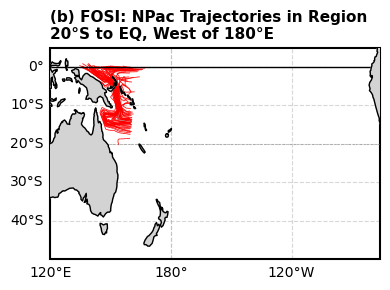

In [133]:
fig, ax = plt.subplots(figsize=(4, 3),
                      subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180, globe=None)})
ax.add_feature(cfeature.LAND, color='lightgray', zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=1., zorder=100)
ax.grid(c='k', linestyle='dashed', alpha=0.2, zorder=4)
ax.set_extent([120, 284, -50, 5], crs=ccrs.PlateCarree())  # Adjust if needed
gl = ax.gridlines(draw_labels={'left': True, 'bottom': True, 'right': False, 'top': False}, 
                  zorder=4, linestyle='--', alpha=0.5)
gl.xlabel_style = {'size': 10, 'color':'k'}
gl.ylabel_style = {'size': 10, 'color':'k'}
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, zorder=5)  # Equator
ax.axhline(y=-20, color='gray', linestyle='--', linewidth=0.5, zorder=5, alpha=0.7)  # 20°S
ax.axvline(x=180, color='gray', linestyle='--', linewidth=0.5, zorder=5, alpha=0.7)  # 180°E
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(1.5)
ax.set_aspect('auto')

# Loop through trajectories
for i in region_idx_SH[::1]:
    lon = lon_data.isel(trajectory=i).values
    lat = lat_data.isel(trajectory=i).values
    time_years = dyr.isel(trajectory=i).values
    
    # Create segments
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create colors for each segment based on position AND time
    filtered_segments = []
    filtered_colors = []
    
    for j in range(len(segments)):
        # Get midpoint of segment for position check
        mid_lon = (lon[j] + lon[j+1]) / 2
        mid_lat = (lat[j] + lat[j+1]) / 2
        mid_time = time_years[j]  # Or average if needed
        
        # CHECK POSITION FILTERS: 20S to EQ AND west of 180°E
        in_lat_range = (-20 <= mid_lat <= 0)  # 20°S to Equator
        in_lon_range = (mid_lon <= 160)      # West of 180°E
        
        if in_lat_range and in_lon_range:
            filtered_segments.append(segments[j])
            
            # Color by time: bright red for 1968-1973, gray otherwise
            if 1968 <= mid_time <= 1979:
                filtered_colors.append((1, 0, 0, 0.9))  # RGBA: bright red
            else:
                # Gray for other years
                filtered_colors.append((0.6, 0.6, 0.6, 0.6))  # RGBA: semi-transparent gray
    
    # Only add collection if there are filtered segments
    if filtered_segments:
        lc = mcollections.LineCollection(
            filtered_segments,
            colors=filtered_colors,
            linewidth=0.6,  # Thicker for emphasis
            transform=ccrs.PlateCarree())
        ax.add_collection(lc)

# ax.legend(handles=legend_elements, loc='lower left', fontsize=8)

plt.title('(b) FOSI: NPac Trajectories in Region\n20°S to EQ, West of 180°E', 
          fontsize=11, fontweight='bold', zorder=12, loc='left')
plt.tight_layout()
plt.show()

In [170]:
first_crossing_indices = []

for i in region_idx_SH[::1]:
    lon = lon_data.isel(trajectory=i).values
    crossing_mask = lon < 160
    crossing_indices = np.where(crossing_mask)[0]
    
    if len(crossing_indices) > 0:
        first_idx = crossing_indices[0]  # First crossing
        time_at_crossing = dyr.isel(trajectory=i).values[first_idx]
        lat_at_crossing = lat_data.isel(trajectory=i).values[first_idx]
        
        first_crossing_indices.append({
            'trajectory_idx': i,
            'first_crossing_index': first_idx,
            'time': time_at_crossing,
            'lon': lon[first_idx],
            'lat': lat_at_crossing
        })
        print(f"Trajectory {i}: First crosses west of 160°E at index {first_idx}, "
              f"year {time_at_crossing:.1f}, position ({lon[first_idx]:.1f}°E, {lat_at_crossing:.1f}°N)")
    else:
        print(f"Trajectory {i}: Never crosses west of 160°E")

# Summary statistics
if first_crossing_indices:
    times = [item['time'] for item in first_crossing_indices]
    indices = [item['first_crossing_index'] for item in first_crossing_indices]
    
    print(f"\nSummary:")
    print(f"  {len(first_crossing_indices)}/{len(region_idx_SH)} trajectories cross west of 160°E")
    print(f"  Average crossing time: {np.mean(times):.1f} ± {np.std(times):.1f} years")
    print(f"  Average crossing index: {np.mean(indices):.0f} ± {np.std(indices):.0f}")
    print(f"  Time range: {min(times):.1f} to {max(times):.1f} years")

Trajectory 107: Never crosses west of 160°E
Trajectory 108: Never crosses west of 160°E
Trajectory 109: Never crosses west of 160°E
Trajectory 110: Never crosses west of 160°E
Trajectory 111: First crosses west of 160°E at index 235, year 1977.3, position (159.8°E, -13.3°N)
Trajectory 112: First crosses west of 160°E at index 215, year 1975.8, position (159.0°E, -14.7°N)
Trajectory 113: First crosses west of 160°E at index 204, year 1974.8, position (159.8°E, -12.5°N)
Trajectory 114: First crosses west of 160°E at index 207, year 1975.1, position (159.2°E, -10.9°N)
Trajectory 115: First crosses west of 160°E at index 194, year 1974.0, position (159.1°E, -13.2°N)
Trajectory 116: First crosses west of 160°E at index 237, year 1977.5, position (159.6°E, -4.8°N)
Trajectory 117: Never crosses west of 160°E
Trajectory 118: Never crosses west of 160°E
Trajectory 127: Never crosses west of 160°E
Trajectory 128: Never crosses west of 160°E
Trajectory 129: First crosses west of 160°E at index 23

In [ ]:
0: 186 ± 36
80: 193 ± 33
65: 184 ± 33
32: 181 ± 38
85: 183 ± 36
61: 176 ± 31
90: 179 ± 31
68: 184 ± 29
73: 179 ± 35
49: 178 ± 35

#### PLOTTING

In [172]:
FOSI_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/FOSI_SH_traj_PD_fullarray.npy')
LENS0_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH0_traj_PD_fullarray.npy')
LENS65_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH65_traj_PD_fullarray.npy')
LENS32_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH32_traj_PD_fullarray.npy')
LENS85_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH85_traj_PD_fullarray.npy')
LENS61_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH61_traj_PD_fullarray.npy')
LENS90_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH90_traj_PD_fullarray.npy')
LENS80_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH80_traj_PD_fullarray.npy')
LENS68_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH68_traj_PD_fullarray.npy')
LENS73_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH73_traj_PD_fullarray.npy')
LENS49_pd_obs_array = np.load('/glade/derecho/scratch/cassiacai/LENS_SH49_traj_PD_fullarray.npy')

In [ ]:
FOSI_interp_ls = []
for i in range(60):
    FOSI_interp_ls.append(interpolate_array(FOSI_pd_obs_array[i,:]))

In [234]:
# Dictionary to store all interpolated arrays
lens_interpolated = {}

# List of all your LENS arrays with their names
lens_arrays = {
    'LENS0': LENS0_pd_obs_array,
    'LENS32': LENS32_pd_obs_array,
    'LENS49': LENS49_pd_obs_array,
    'LENS61': LENS61_pd_obs_array,
    'LENS65': LENS65_pd_obs_array,
    'LENS68': LENS68_pd_obs_array,
    'LENS73': LENS73_pd_obs_array,
    'LENS80': LENS80_pd_obs_array,
    'LENS85': LENS85_pd_obs_array,
    'LENS90': LENS90_pd_obs_array
}

# Process each array
for name, arr in lens_arrays.items():
    interp_ls = []
    
    # Get number of trajectories (rows)
    n_trajectories = arr.shape[0]
    
    for i in range(n_trajectories):
        interp_ls.append(interpolate_array(arr[i, :]))
    
    lens_interpolated[name] = np.asarray(interp_ls)
    
    print(f"Processed {name}: {n_trajectories} trajectories, shape {lens_interpolated[name].shape}")

Processed LENS0: 60 trajectories, shape (60, 244)
Processed LENS32: 60 trajectories, shape (60, 244)
Processed LENS49: 60 trajectories, shape (60, 244)
Processed LENS61: 60 trajectories, shape (60, 244)
Processed LENS65: 60 trajectories, shape (60, 244)
Processed LENS68: 60 trajectories, shape (60, 244)
Processed LENS73: 60 trajectories, shape (60, 244)
Processed LENS80: 60 trajectories, shape (60, 244)
Processed LENS85: 60 trajectories, shape (60, 244)
Processed LENS90: 60 trajectories, shape (60, 244)


In [268]:
first_t = 5*12.2
print(first_t)

61.0


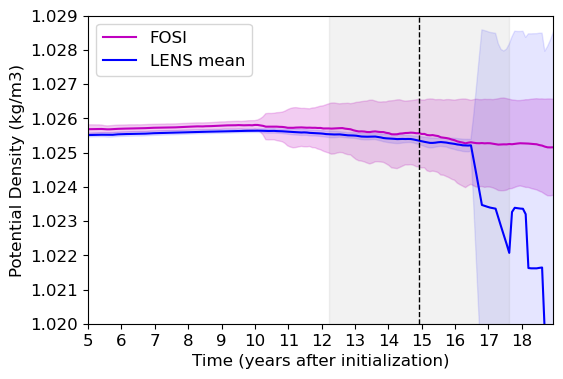

In [266]:
# Collect all LENS interpolated arrays from dictionary
lens_arrays = list(lens_interpolated.values())  # This gets [LENS0_interp_array, LENS32_interp_array, ...]

# Or if you want them in a specific order:
lens_arrays = [
    lens_interpolated['LENS0'],
    lens_interpolated['LENS32'],
    lens_interpolated['LENS49'],
    lens_interpolated['LENS61'],
    lens_interpolated['LENS65'],
    lens_interpolated['LENS68'],
    lens_interpolated['LENS73'],
    lens_interpolated['LENS80'],
    lens_interpolated['LENS85'],
    lens_interpolated['LENS90']
]

plt.figure(figsize=(6, 4))
plt.plot(np.arange(244), FOSI_interp_array.mean(axis=0), c='m', linewidth=1.5, label='FOSI')
plt.fill_between(range(len(FOSI_interp_array.mean(axis=0))), 
                 FOSI_interp_array.mean(axis=0) - FOSI_interp_array.std(axis=0),
                 FOSI_interp_array.mean(axis=0) + FOSI_interp_array.std(axis=0),
                 alpha=0.2, color='m')
lens_means = np.array([arr.mean(axis=0) for arr in lens_arrays])
lens_ensemble_mean = lens_means.mean(axis=0)
lens_ensemble_std = lens_means.std(axis=0)

plt.plot(np.arange(len(lens_ensemble_mean)), lens_ensemble_mean, 
         c='blue', linewidth=1.5, label='LENS mean')
plt.fill_between(range(len(lens_ensemble_mean)),
                 lens_ensemble_mean - lens_ensemble_std,
                 lens_ensemble_mean + lens_ensemble_std,
                 alpha=0.1, color='blue')

units_per_year = 12.2
start_year = 5
left_bound = 61
right_bound = 231

first_tick_pos = np.ceil(left_bound / units_per_year) * units_per_year
tick_positions = np.arange(first_tick_pos, right_bound + 1e-6, units_per_year)

year_labels = [(pos - left_bound) / units_per_year + start_year for pos in tick_positions]

formatted_labels = [f"{year:.0f}" for year in year_labels]
plt.xticks(tick_positions, formatted_labels, fontsize=12)

plt.xlim(first_t, 231)
plt.axvspan(182-33, 182+33, alpha=0.1, color='gray')
plt.axvline(x=182, c='k', linestyle='dashed', linewidth=1.)
plt.ylim(1.02, 1.029)
plt.yticks(fontsize=12)
plt.xlabel('Time (years after initialization)', fontsize=12)
plt.ylabel('Potential Density (kg/m3)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()